# Neural network examples
This jupyter notebook was used to run the neural network examples, and used to produce the plots. 


In [1]:
%matplotlib inline
import sys
sys.path.append('../../src')

from scripts.utils import maybe_makedirs
import matplotlib.pyplot as plt

from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
from torch.utils.data import Dataset, DataLoader

import numpy as np
import os
import pickle
import torch
import pickle
import stlcg

In [2]:
import matplotlib 
matplotlib.rc('xtick', labelsize=20) 
matplotlib.rc('ytick', labelsize=20) 

# Bump example

In [3]:
#### Settings ####
fig_dir = "figs/neural_network/bump"
data_dir = "data/neural_network/bump"
maybe_makedirs(fig_dir)
maybe_makedirs(data_dir)

### generating bump data

In [4]:
x = np.arange(-2,2,0.1)
y = np.zeros(4*10)
y[:10] = -0.5
y[10:30] = 0.5
y[30:] = -0.5
y += np.random.randn(40)*0.1

Text(0.5, 1.0, 'Bump data')

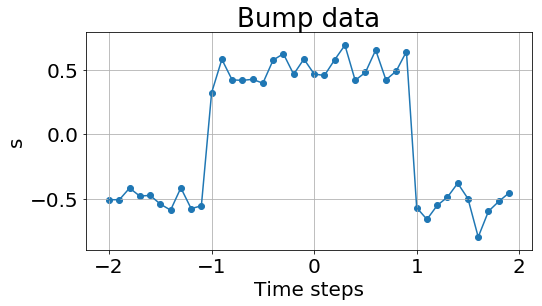

In [5]:
plt.figure(figsize=(8,4))
plt.plot(x,y)
plt.scatter(x,y)
plt.grid()
plt.xlabel("Time steps", fontsize=20)
plt.ylabel("s", fontsize=20)
plt.title("Bump data", fontsize=26)

## creating a (very simple) neural network

In [6]:
class Bump(torch.nn.Module):

    def __init__(self, n, m, hidden_dim):
        super(Bump, self).__init__()
        self.network = torch.nn.Sequential(torch.nn.Linear(n, hidden_dim),
                                           torch.nn.ReLU(),
                                           torch.nn.Linear(hidden_dim, m))
    

    
    def forward(self, x):        
        return self.network(x)
    
# creating the bump neural network


In [7]:
bump = Bump(4, 40, 4)

### creating input data

In [8]:
xx = torch.as_tensor(np.arange(-1,1,0.5)).float()
yy = torch.as_tensor(y).float()
# regularize the weights as well
optimizer = torch.optim.Adam(bump.parameters(), lr=0.01, weight_decay=0.10)

a = torch.as_tensor(0.48).float()
b = torch.as_tensor(0.52).float()

### creating stl formula

In [9]:
y_exp = stlcg.Expression('y_exp')
ϕ1 = y_exp > a
ϕ2 = y_exp < b
ϕ = stlcg.Always(subformula=ϕ1, interval=[10,29]) & stlcg.Always(subformula=ϕ2, interval=[10,29])
print(ϕ)

(◻ [10, 29]( y_exp >= input )) ∧ (◻ [10, 29]( y_exp <= input ))


### training network

In [ ]:
##### hyperparameters #####
γ = 0.0  # weighting on robustness loss
###########################
data_path = data_dir + "/robustness_weight=%.2f"%γ
maybe_makedirs(data_path)

for _ in range(1000):
    optimizer.zero_grad()
    y_pred = bump(xx)
    ϕ_input = y_pred.unsqueeze(0).unsqueeze(-1)
    robustness = ϕ.robustness((ϕ_input, ϕ_input), scale=-1)
    mse = (y_pred - yy).pow(2).sum()
    loss = mse + γ*torch.relu(-robustness).squeeze()
    loss.backward()

    optimizer.step()
    if (_ % 50) == 0:
        print("%i loss = %.3f   mse = %.3f    robustness = %.3f"%(_, loss.detach().numpy(), mse.detach().numpy(), robustness.squeeze()))

### saving data and model

In [62]:
np.save(data_path + "/data.npy", np.stack([x, y, bump(xx).detach().numpy()]))
PATH = data_path + "/model.pt"
torch.save(bump.state_dict(), PATH)

### plotting

In [4]:
# choose which gamma value to plot
γ = 10.0
data_path = data_dir + "/robustness_weight=%.2f"%γ

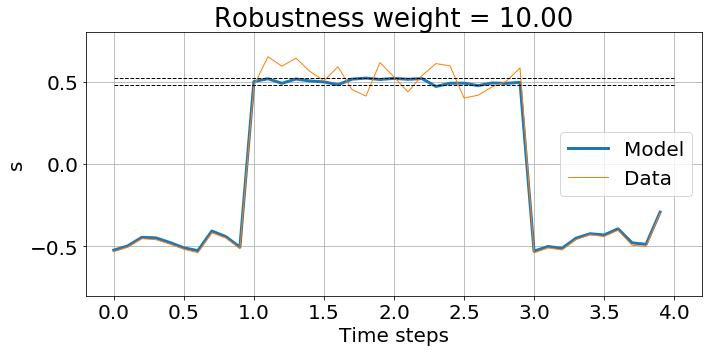

In [6]:
fig_path = fig_dir + "/robustness_weight=%.2f"%γ
maybe_makedirs(fig_path)

plt.figure(figsize=(10,5))
a = torch.as_tensor(0.48).float()
b = torch.as_tensor(0.52).float()
data = np.load(data_path + "/data.npy")
xx = data[0,:]
yy = data[1,:]
y_pred = data[2,:]
plt.plot(xx+2, y_pred, linewidth=3, label="Model")
plt.plot(xx+2, yy, linewidth=1, label="Data")
plt.plot([0,4],[a.numpy()]*2, 'k--', linewidth=1)
plt.plot([0,4],[b.numpy()]*2, 'k--', linewidth=1)
plt.ylim([-0.8, 0.8])
plt.xlabel("Time steps", fontsize=20)
plt.ylabel("s", fontsize=20)
plt.legend(fontsize=20)
plt.title("Robustness weight = %.2f"%γ, fontsize=26)
plt.grid()
plt.tight_layout()
# plt.savefig(fig_path + "/plot.png")

# Intent prediction example

In [14]:
#### Settings ####
fig_dir = "figs/neural_network/intent"
data_dir = "data/neural_network/intent"
maybe_makedirs(fig_dir)
maybe_makedirs(data_dir)

### generating data

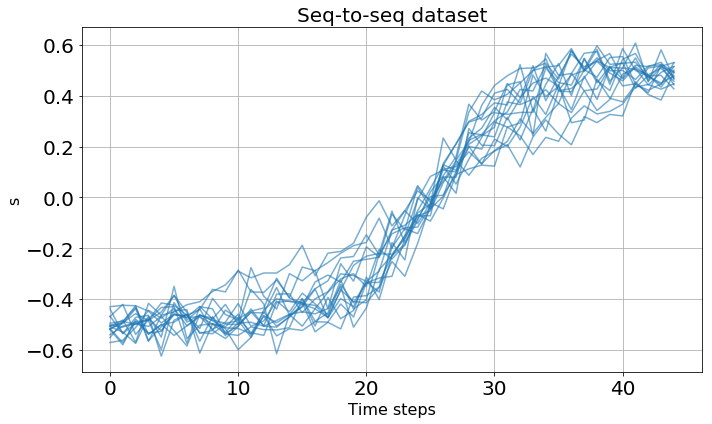

In [15]:
xx = np.arange(-2.5, 2, 0.1)
N = 256
x = np.stack([xx for i in range(N)])
y = 0.5*np.tanh(x * (0.3 + np.random.rand(N,1)*2)) + np.random.randn(*x.shape)*0.05
np.save(data_dir + "/train.npy", np.stack([x, y], axis=-1))


N = 16
x = np.stack([xx for i in range(N)])
y = 0.5*np.tanh(x * (0.3 + np.random.rand(N,1)*2)) + np.random.randn(*x.shape)*0.05
np.save(data_dir + "/test.npy", np.stack([x, y], axis=-1))


plt.figure(figsize=(10,6))
plt.plot(y.T, alpha=0.6, c='#1f77b4')

plt.grid()
plt.xlabel("Time steps", fontsize=16)
plt.ylabel("s", fontsize=16)
plt.title("Seq-to-seq dataset", fontsize=20)
plt.tight_layout()


### creating a neural network model

In [16]:
class PredictionDataset(Dataset):

    def __init__(self, fname, history_length=10, prediction_length=10):
        """
        Args:
            csv_file (string): Path to the csv file with annotations.
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.data = np.load(fname)
        self.history_length = history_length
        self.prediction_length = prediction_length

    def __len__(self):
        return self.data.shape[0]

    def __getitem__(self, idx):
        x = self.data[idx, :self.history_length, :]
        y = self.data[idx, self.history_length:self.history_length+self.prediction_length, :]
        return {'x': x, 'y': y}
    
class Encoder(torch.nn.Module):

    def __init__(self, lstm_input_dim, lstm_dim):
        super(Encoder, self).__init__()
        self.network = torch.nn.LSTM(lstm_input_dim, lstm_dim, batch_first=True)
    
    def forward(self, x):
        return self.network(x)
    
class Decoder(torch.nn.Module):

    def __init__(self, lstm_input_dim, lstm_dim):
        super(Decoder, self).__init__()
        self.rnn_network = torch.nn.LSTM(lstm_input_dim, lstm_dim, batch_first=True)
        self.proj_network = torch.nn.Linear(lstm_dim, lstm_input_dim)
        self.h0 = torch.zeros([1,1,lstm_dim])
    
    def forward(self, x, rnn_state, ph):
        bs = x.shape[0]
        y_out = []
        for t in range(ph):
            output, rnn_state = self.rnn_network(x, rnn_state)
            x = self.proj_network(output)
            y_out.append(x)
        return torch.cat(y_out, dim=1)
    
class Predict(torch.nn.Module):

    def __init__(self, lstm_input_dim, lstm_dim):
        super(Predict, self).__init__()
        
        self.enc = Encoder(lstm_input_dim, lstm_dim)
        self.dec = Decoder(lstm_input_dim, lstm_dim)
        
    def forward(self, x, ph):
        enc_out, rnn_state = self.enc(x)
        return self.dec(self.dec.proj_network(enc_out[:,-1:,:]), rnn_state, ph)




In [17]:
pred = Predict(1, 4)
dataset = PredictionDataset(data_dir + "/train.npy")

train_loader = DataLoader(dataset, batch_size=8, shuffle=True)


### setting up stl formula

In [18]:
yf = stlcg.Expression('yf')
ϕ2 = yf > torch.as_tensor(0.4).float()
ϕ3 = yf < torch.as_tensor(0.6).float()
ϕ = ϕ2 & ϕ3
ψ = stlcg.Always(subformula=ϕ, interval=[0,5])

### training the network

In [19]:
##### hyperparameters #####
γ = 0.0     # weighting on robustness loss
lr = 0.01
###########################
data_path = data_dir + "/robustness_weight=%.2f"%γ
maybe_makedirs(data_path)
fig_path = fig_dir + "/robustness_weight=%.2f"%γ
maybe_makedirs(fig_path)

In [ ]:

optimizer = torch.optim.Adam(pred.parameters(), lr=lr, weight_decay=0.00)

for _ in range(50):
    for batch_idx, data_dict in enumerate(train_loader):
        x = data_dict['x'].float()[:,:,1:]
        y = data_dict['y'].float()[:,:,1:]
        optimizer.zero_grad()
        y_pred = pred(x, 35)
        y_loss = y_pred[:,:10,:]

        y_future = y_pred[:,-35:,:]

        robustness = torch.relu(-ψ.robustness((y_future, y_future), scale=-1)).sum()
        mse = (y_loss - y).pow(2).sum(-1).mean(1).mean()
        loss = mse + γ*robustness
        loss.backward()

        optimizer.step()
    print("%i loss = %.3f   mse = %.3f    robustness = %.3f"%(_, loss.detach().numpy(), mse.detach().numpy(), robustness.squeeze()))

### saving model

In [22]:
PATH = data_path + "/model.pt"
torch.save(pred.state_dict(), PATH)

### preparing test set data

In [20]:
dataset = PredictionDataset(data_dir + "/test.npy")
test_loader = DataLoader(dataset, batch_size=16, shuffle=False)
for batch_idx, data_dict in enumerate(test_loader):
    x = data_dict['x'].float()[:,:,1:]
    y = data_dict['y'].float()[:,:,1:]
    break

In [23]:
γ = 0.0     # 0.1 # weighting on robustness loss
data_path = data_dir + "/robustness_weight=%.2f"%γ
PATH = data_path + "/model.pt"

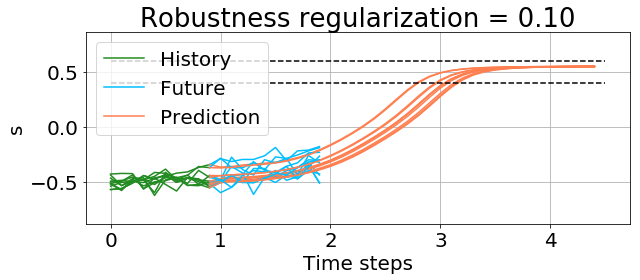

In [24]:
model = Predict(1, 4)

plt.figure(figsize=(9, 4))

model.load_state_dict(torch.load(PATH))
model.eval()
y_pred = model(x, 35)
np.save(data_path + "/data.npy", np.stack([x, y]))
np.save(data_path + "/output.npy", y_pred.detach().numpy())



for idx in range(0,1):
    x_history = xx[:10]
    history = x.numpy()[idx,:,:]
    plt.plot(x_history+2.5, history, c="forestgreen", label="History")
    
    x_future = xx[9:20]
    future = y.numpy()[idx,:,:]
    future = np.concatenate([history[-1:,:], future], axis=0)
    plt.plot(x_future+2.5, future, c="deepskyblue", label="Future")
    
    x_future = xx[9:]
    future = y_pred.detach().numpy()[idx,:,:]
    future = np.concatenate([history[-1:,:], future], axis=0)
    plt.plot(x_future+2.5, future, c="coral", label="Prediction")
    
    

for idx in range(0,10):
    x_history = xx[:10]
    history = x.numpy()[idx,:,:]
    plt.plot(x_history+2.5, history, c="forestgreen")
    
    x_future = xx[9:20]
    future = y.numpy()[idx,:,:]
    future = np.concatenate([history[-1:,:], future], axis=0)
    plt.plot(x_future+2.5, future, c="deepskyblue")
    
    x_future = xx[9:]
    future = y_pred.detach().numpy()[idx,:,:]
    future = np.concatenate([history[-1:,:], future], axis=0)
    plt.plot(x_future+2.5, future, c="coral")

plt.plot([0,4.5],[0.4, 0.4], 'k--')
plt.plot([0,4.5],[0.6, 0.6], 'k--')
plt.xlim([-2.5, 2])
plt.xlim([-1, 1])
plt.axis("equal")
plt.legend(loc="upper left", fontsize=20)
plt.title("Robustness regularization = %.2f"%γ, fontsize=26)
plt.xlabel("Time steps", fontsize=20)
plt.ylabel("s", fontsize=20)
plt.tight_layout()
plt.grid()

# plt.savefig(fig_path + "/plot.png")

## After running the code for $\gamma = 0$, and $\gamma \neq 0$, plot the side-by-side comparison plot

In [25]:
# The non-zero gamma value
γ = 0.1

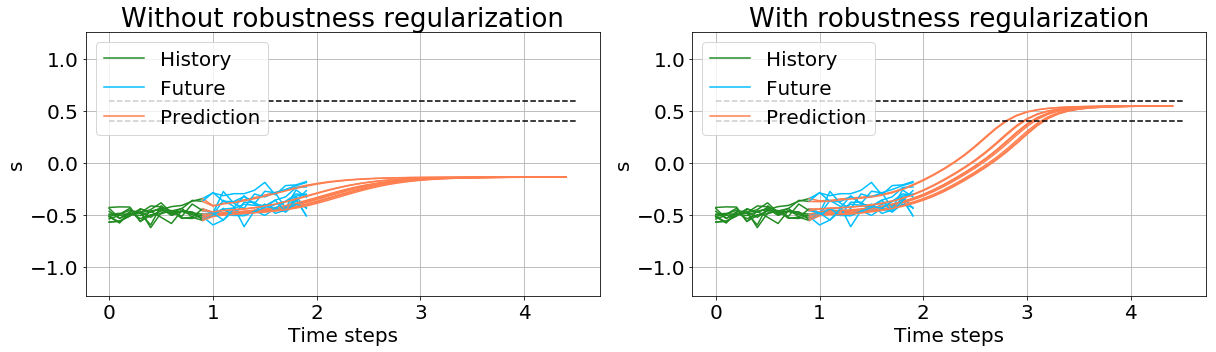

In [26]:
xx = np.arange(-2.5, 2, 0.1)

plt.figure(figsize=(17, 5))

plt.subplot(1,2,1)
PATH = data_dir + "/robustness_weight=0.00/model.pt"
model.load_state_dict(torch.load(PATH))
model.eval()
y_pred = model(x, 35)
for idx in range(0,1):
    x_history = xx[:10]
    history = x.numpy()[idx,:,:]
    plt.plot(x_history+2.5, history, c="forestgreen", label="History")
    
    x_future = xx[9:20]
    future = y.numpy()[idx,:,:]
    future = np.concatenate([history[-1:,:], future], axis=0)
    plt.plot(x_future+2.5, future, c="deepskyblue", label="Future")
    
    x_future = xx[9:]
    future = y_pred.detach().numpy()[idx,:,:]
    future = np.concatenate([history[-1:,:], future], axis=0)
    plt.plot(x_future+2.5, future, c="coral", label="Prediction")
    
    

for idx in range(0,10):
    x_history = xx[:10]
    history = x.numpy()[idx,:,:]
    plt.plot(x_history+2.5, history, c="forestgreen")
    
    x_future = xx[9:20]
    future = y.numpy()[idx,:,:]
    future = np.concatenate([history[-1:,:], future], axis=0)
    plt.plot(x_future+2.5, future, c="deepskyblue")
    
    x_future = xx[9:]
    future = y_pred.detach().numpy()[idx,:,:]
    future = np.concatenate([history[-1:,:], future], axis=0)
    plt.plot(x_future+2.5, future, c="coral")

plt.plot([0,4.5],[0.4, 0.4], 'k--')
plt.plot([0,4.5],[0.6, 0.6], 'k--')
plt.xlim([-2.5, 2])
plt.xlim([-1, 1])
plt.axis("equal")
plt.legend(loc="upper left", fontsize=20)
plt.title("Without robustness regularization", fontsize=26)
plt.xlabel("Time steps", fontsize=20)
plt.ylabel("s", fontsize=20)
plt.tight_layout()
plt.grid()

plt.subplot(1,2,2)

PATH = data_dir + "/robustness_weight=%.2f/model.pt"%γ
model.load_state_dict(torch.load(PATH))
model.eval()
y_pred = model(x, 35)
for idx in range(0,1):
    x_history = xx[:10]
    history = x.numpy()[idx,:,:]
    plt.plot(x_history+2.5, history, c="forestgreen", label="History")
    
    x_future = xx[9:20]
    future = y.numpy()[idx,:,:]
    future = np.concatenate([history[-1:,:], future], axis=0)
    plt.plot(x_future+2.5, future, c="deepskyblue", label="Future")
    
    x_future = xx[9:]
    future = y_pred.detach().numpy()[idx,:,:]
    future = np.concatenate([history[-1:,:], future], axis=0)
    plt.plot(x_future+2.5, future, c="coral", label="Prediction")
    
    

for idx in range(0,10):
    x_history = xx[:10]
    history = x.numpy()[idx,:,:]
    plt.plot(x_history+2.5, history, c="forestgreen")
    
    x_future = xx[9:20]
    future = y.numpy()[idx,:,:]
    future = np.concatenate([history[-1:,:], future], axis=0)
    plt.plot(x_future+2.5, future, c="deepskyblue")
    
    x_future = xx[9:]
    future = y_pred.detach().numpy()[idx,:,:]
    future = np.concatenate([history[-1:,:], future], axis=0)
    plt.plot(x_future+2.5, future, c="coral")

plt.plot([0,4.5],[0.4, 0.4], 'k--')
plt.plot([0,4.5],[0.6, 0.6], 'k--')
plt.xlim([-2.5, 2])
plt.xlim([-1, 1])
plt.axis("equal")
plt.legend(loc="upper left", fontsize=20)
plt.title("With robustness regularization", fontsize=26)
plt.xlabel("Time steps", fontsize=20)
plt.ylabel("s", fontsize=20)
plt.tight_layout()
plt.grid()

